# Проект - Credit Scoring

Первая и самая важная цель банка — заработать деньги. Если банк будет вести слишком жесткую политику, не выдавая кредиты даже тем, кто вернул бы деньги, то он не заработает на процентах. Отказ в кредите хорошему заемщику — ошибка первого рода. Риск, с которым сталкивается кредитная организация — дать кредит неблагонадёжному заёмщику, который впоследствии может допустить дефолт, а банк потеряет деньги — ошибка второго рода.
	
Чтобы соблюсти баланс, используется кредитный скоринг, который позволяет спрогнозировать вероятность невозврата кредита. Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — рейтинг клиентов от плохих к хорошим. 

Используя данные о клиенте, работник банка может решить, выдавать ли клиенту кредит, и если да, то под какой процент.

При этом используемый в кредитном скоринге алгоритм позволяет предсказывать значения непрерывной зависимой переменной на интервале от  до . Банки самостоятельно определяют для себя значения, при которых они принимают решение об отказе в кредите.

Цель проекта - выбрать наиболее эффективную модель оценки качества клиентов банка.

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoost, CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
import lightgbm
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

# settings to display all columns
pd.set_option("display.max_columns", None)

RANDOM_SEED = 42

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# dir_data = './drive/MyDrive/Stud/SkillFactory/Unit_5/project_5/'

In [2]:
def get_boxplot(df, col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=df[df['sample']==1], ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
    
    
def age_to_cat(age):
    if age <= 28:
        cat_age = 0
        return cat_age             
    if 28 < age <= 35:
        cat_age = 1
        return cat_age
    if 35 < age <= 50:
        cat_age = 2
        return cat_age
    if age > 50:
        cat_age = 3
        return cat_age
    
    
def show_metrics(y_test, y_pred, probs):
    print('accuracy_score:\t\t {:.4}'.format(accuracy_score(y_test, y_pred)))
    print('precision_score:\t {:.4}'.format(precision_score(y_test, y_pred, zero_division=0)))
    print('recall_score:\t\t {:.4}'.format(recall_score(y_test, y_pred, zero_division=0)))
    print('f1_score:\t\t {:.4}'.format(f1_score(y_test, y_pred, zero_division=0)))
    print('roc_auc_score:\t\t {:.4}'.format(roc_auc_score(y_test, probs)))
    
def show_basic_models(df):
    train_df = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)

    X = train_df.drop(['default'], axis=1).values
    y = train_df['default'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=0.20, 
        random_state=RANDOM_SEED
    )
    
    # models with default settings
    lr = LogisticRegression(max_iter=1000) # fix ConvergenceWarning
    tree = DecisionTreeClassifier()
    extra_tree = ExtraTreeClassifier()
    ada = AdaBoostClassifier()
    bagg = BaggingClassifier()
    extra_ens = ExtraTreesClassifier()
    gboost = GradientBoostingClassifier()
    rforest = RandomForestClassifier()
    catboo = CatBoostClassifier(silent=True) # silent=True to hide logs

    models = [
        lr,
        tree,
        extra_tree,
        ada,
        bagg,
        extra_ens,
        gboost,
        rforest,
        catboo
    ]

    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        probs = model.predict_proba(X_test)
        probs = probs[:,1]

        # zero_division=0 to fix zero division Warning
        print('Results for:', model)
        show_metrics(y_test, y_pred, probs)
        print('---------')
        print()
        
    
def compute_selected_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    show_metrics(y_test, y_pred, probs)
    return y_pred, probs

In [3]:
path = '/kaggle/input/sf-dst-scoring/'

In [4]:
train = pd.read_csv(path +'train.csv')
test = pd.read_csv(path +'test.csv')
sample = pd.read_csv(path +'sample_submission.csv')

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# sample = pd.read_csv('sample_submission.csv')

# train = pd.read_csv(dir_data+'train.csv')
# test = pd.read_csv(dir_data+'test.csv')
# sample = pd.read_csv(dir_data+'sample_submission.csv')

In [5]:
# profile = train.profile_report()
# profile.to_file('data_report.html')

In [6]:
print(train.info())
print()
print('Train size: ', train.shape)
print()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
print(test.info())
print()
print('Test size: ', test.shape)
print()
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [8]:
print(sample.info())
print()
print('Sample size: ', sample.shape)
print()
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None

Sample size:  (24354, 2)



,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


## Описания полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

<AxesSubplot:title={'center':'Distribution of "Default" feature'}, ylabel='default'>

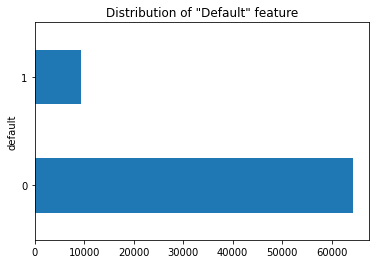

In [9]:
# посмотрим на целевую переменную
train['default'].value_counts().plot(
    kind='barh',
    title='Distribution of "Default" feature',
    ylabel='cases',
    xlabel='default'
)

Note: Выборка несбалансированная.

In [10]:
# объединим датасеты для удобства предварительной обработки
train['sample'] = 1   # train
test['sample'] = 0    # test
test['default'] = -1

data = pd.concat([train, test], ignore_index=True)

# num of unique values, first 10 unique values, null values count, type
data_agg = data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()

data_agg

,<lambda>,nunique,null,dtype
client_id,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",110148,0,int64
app_date,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",120,0,object
education,"[SCH, GRD, UGR, PGR, ACD, nan]",5,478,object
sex,"[M, F]",2,0,object
age,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29]",52,0,int64
car,"[Y, N]",2,0,object
car_type,"[Y, N]",2,0,object
decline_app_cnt,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9]",24,0,int64
good_work,"[0, 1]",2,0,int64
score_bki,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",102618,0,float64


In [11]:
print(data.info())
print()
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## EDA

* В наборе даных 19 признаков
* Всего представлено 110 148 клиентоа
* Количество пропусков 0.04%, только в признаке education
* Дубликатов нет
* client_id не имеет повторяющихся значений, все значения уникальные
* app_date только 120 вариантов признака (0.1%). Большинство данных за период февраль-апрель 2014 года
* education содержит 5 категорий:
1. SCH (52%) - School;
2. GRD (31%) - Graduated (Master degree);
3. UGR (13%) - UnderGraduated (Bachelor degree);
4. PGR (1.7%) - PostGraduated;
5. ACD (0.3%) - Academic Degree.
* sex содержит 2 вариации признака:
1. Female (56%);
2. Male (44%);
* age представлен конкретными значениями со смещением влево:
-- Minimum 21
-- median 37
-- Mean 39.2
-- Maximum 72
-- Interquartile range (IQR) 18
* car бинарный признак, 67% заемщиков не имеют автомобиля
* car_type бинарный признак, показывающий отечественный или иностранный автомобиль у заемщика. 81% заемщиков имеют отечественный автомобиль
decline_app_cnt модержит конкретные значения со смещением влево. Большинство значений (83%) нулевые. Преобладающее большинство наблюдений в промежутке от 0 до 6. Можно попробовать преобразовать признак в категориальный
-- Maximum 33

* good_work Mбольшинство заемщиков не имеют хорошей работы (83%)
* score_bki 93% значений уникальны, распределение нормальное, присутствуют отрицательные значения - возможно, здесь уже применялся scaler
* bki_request_cnt натуральыне числа, которые варбируются от 0 до 53 с медианой 1. Большинство значений в промежутке от 0 до 8
* region_rating варбируются между 20 и 80. Категориальный признак. Самое часто встречающееся значение 50 (37%)
* home_address, work_address категориальные признаки с 3 вариациями.

* income большой разброс значений от 1000 до 1000000; можно попробовать либо превратить в категориальный признак, либо прологарифмировать

* sna / first_time категориальные признаки с 4 вариациями значений

* foreign_passport бинарный признак, 67% заемщиков имеют заграничный паспорт

* default целевой признак. Бинарный признак с подавляющим большинством тех, кто возвращает кредит без проблем. Выборка несбалансированная, при моделировании нужно будет попробовать undersampling.

In [12]:
# exclude client_id, app_date, default, sample

num_cols = [
    'age', 
    'decline_app_cnt', 
    'score_bki',
    'income', 
    'bki_request_cnt'
]

cat_cols = [
    'education', 
    'work_address', 
    'home_address', 
    'region_rating' , 
    'sna', 
    'first_time'
]

bin_cols = [
    'sex', 
    'car', 
    'car_type', 
    'good_work', 
    'foreign_passport'
]

## Количественные признаки

<Figure size 432x288 with 0 Axes>

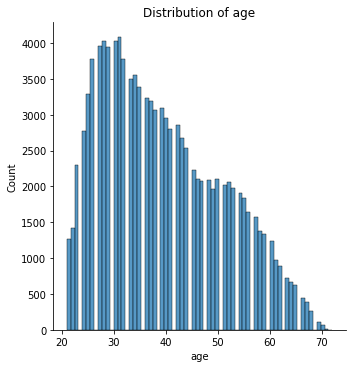

<Figure size 432x288 with 0 Axes>

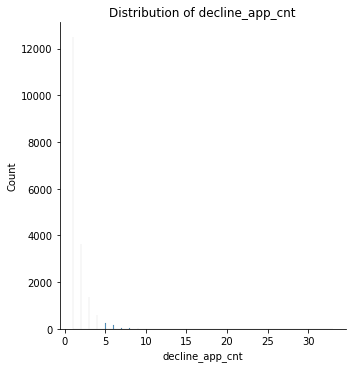

<Figure size 432x288 with 0 Axes>

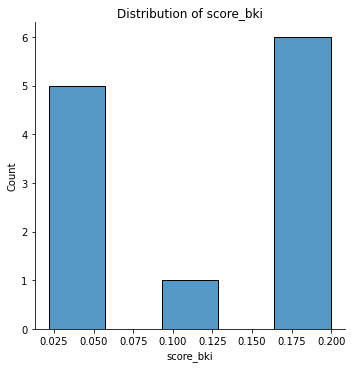

<Figure size 432x288 with 0 Axes>

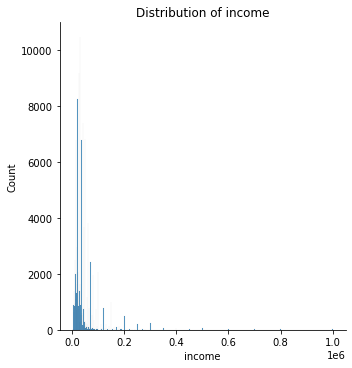

<Figure size 432x288 with 0 Axes>

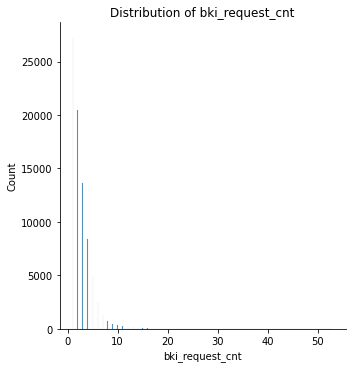

In [13]:
# посмотрим на распределение количественных признаков
for i in num_cols:
    plt.figure()
    sns.displot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(f'Distribution of {i}')
    plt.show()

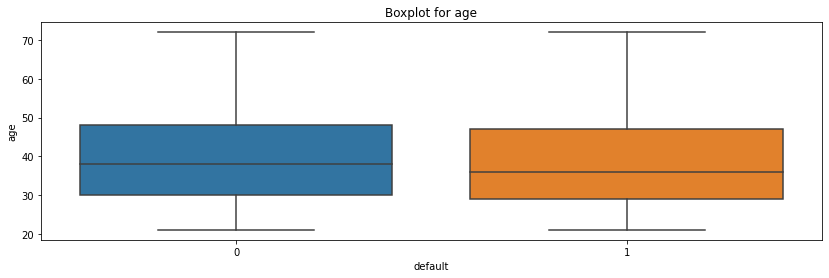

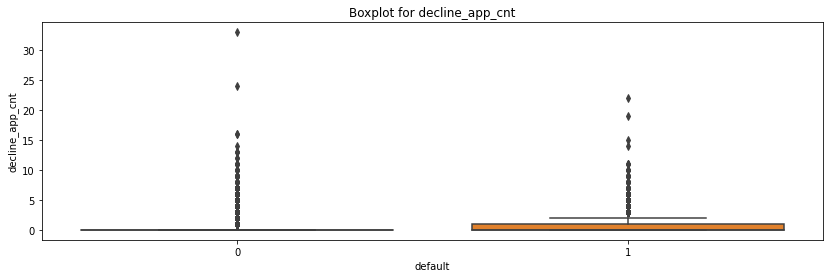

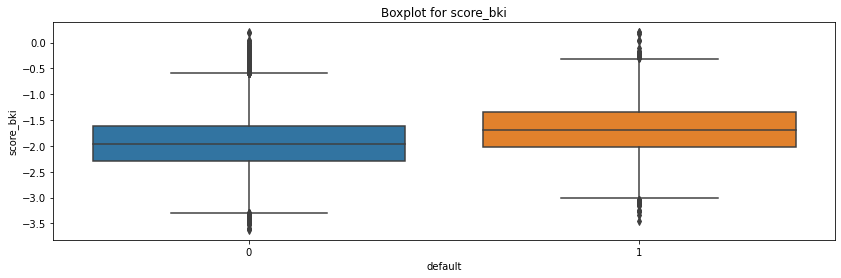

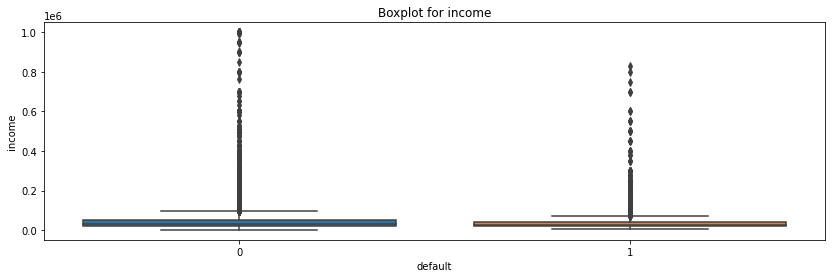

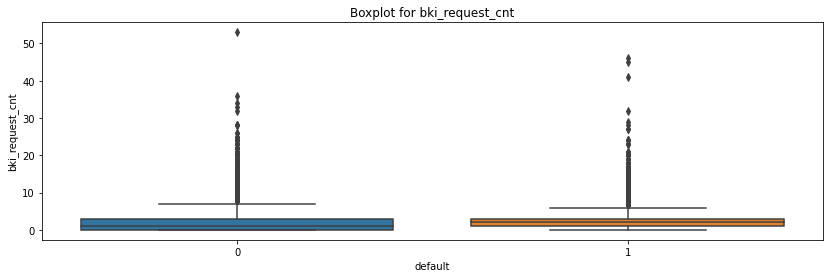

In [14]:
# посмотрим на выбросы
# и распределение целевой переменной между количественными признаками
for col in num_cols:
    get_boxplot(data, col)

Краткие выводы:
* дефолт больше характерен для более молодых
* высокий score_bki характерен для дефолта
* рейтинг региона влияет на целевую переменную
* частые запросы в БКИ характерны для менее уверенных клиентов и могут сигнализировать дефолтную ситуацию
* в среднем, более высокий доход свидетельствует о меньшей вероятности дефолта

## Категориальные признаки

Клиенты с более низким уровнем образования чаще подвержены дефолту. В то же время, они чаще берут кредиты.

Чем ниже рейтинг региона, тем чаще возникает дефолт по кредитам. Но это неверно для двух наименее рейтинговых регионов.

Домашний и рабочий адреса распределены схожим образом. Возможно, есть мультиколлинеарность.

Категории sna: ниже категория - меньше дефолтов. First_time - аналогично.

Пропущенные значения: 478



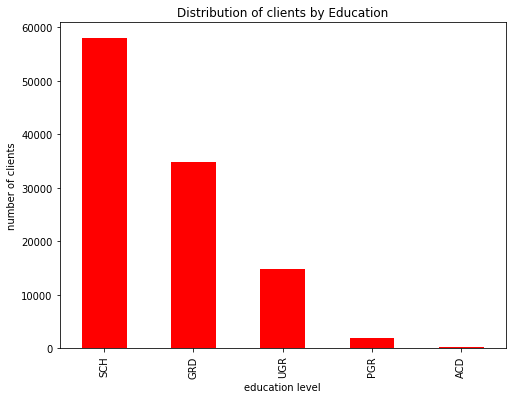

In [15]:
data.education.value_counts().plot(
    kind="bar",
    figsize=(8,6),
    color="r",
    title='Distribution of clients by Education',
    xlabel='education level',
    ylabel='number of clients'
)

print("Пропущенные значения:", data.education.isna().sum())
print()

In [16]:
# заполним пропуски наиболее часто встречающимся значением
data.education = data.education.fillna("SCH")

<AxesSubplot:title={'center':'Distribution of Income by Education level'}, xlabel='education', ylabel='income'>

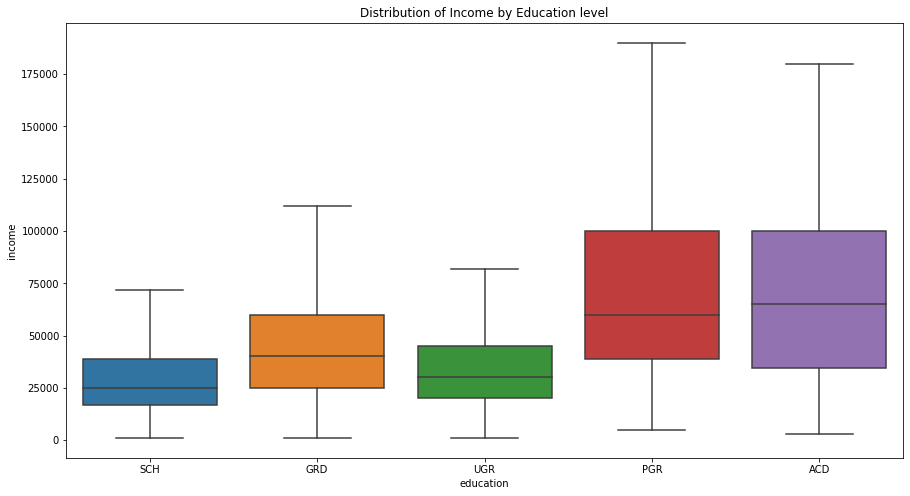

In [17]:
# оценим доход от уровня образования
plt.figure(figsize=(15, 8))
plt.title('Distribution of Income by Education level')
sns.boxplot(
    x="education", 
    y="income", 
    data=data, 
    showfliers=False
)

<AxesSubplot:title={'center':'Distribution of Education level by Region'}, xlabel='education', ylabel='region_rating'>

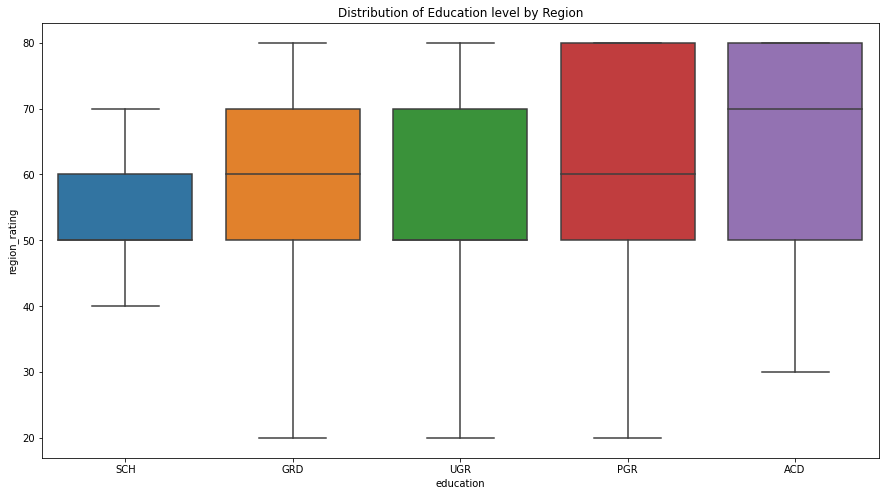

In [18]:
# оценим влияние региона проживания на уровень образования
plt.figure(figsize=(15, 8))
plt.title('Distribution of Education level by Region')
sns.boxplot(
    x="education", 
    y="region_rating", 
    data=data, 
    showfliers=False
)

Люди с более высоким уровнем образования живут в регионах с более высоким рейтингом. И наоборот.

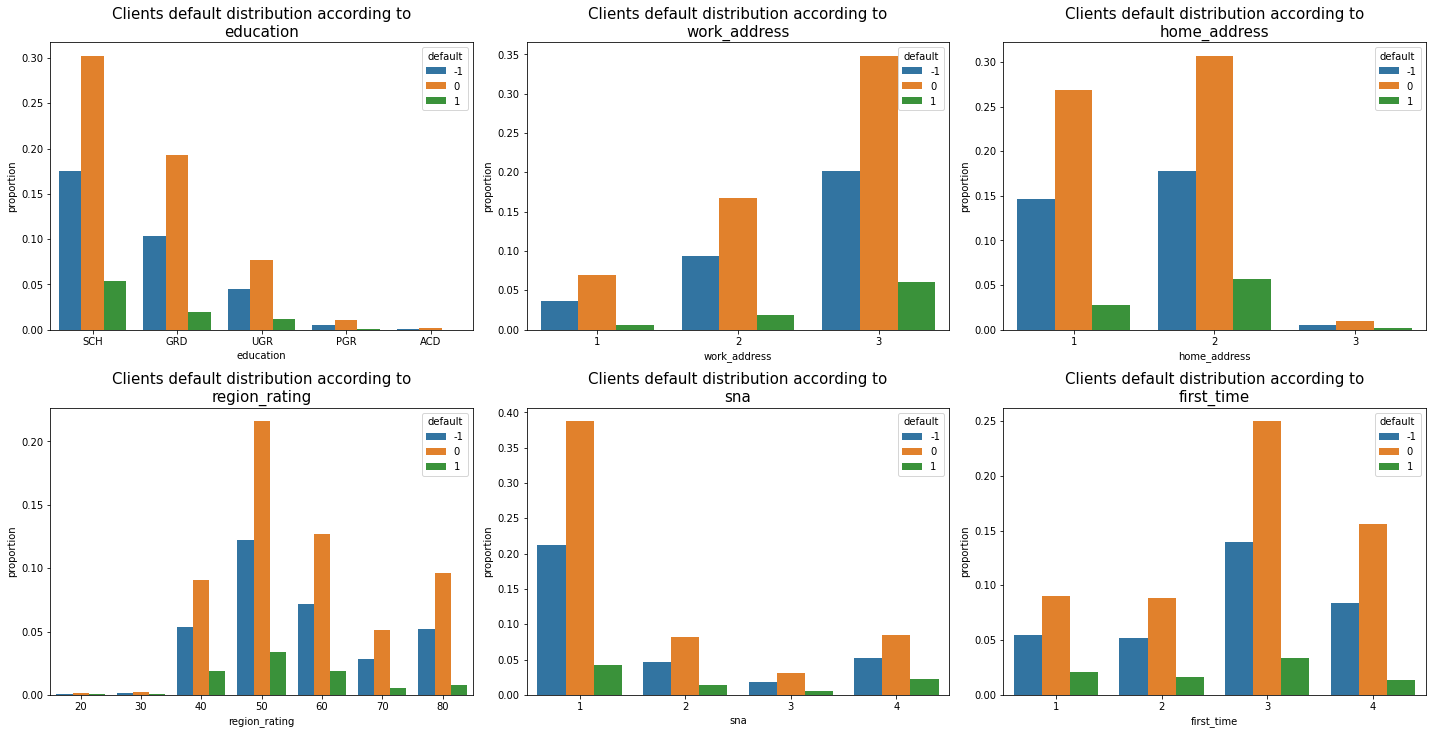

In [19]:
# посмотрим на распределение дефолтных состояний по различным признакам

plt.figure(figsize=[20, 20])
i = 1

for k in cat_cols:
    plt.subplot(4, 3, i)
    sns.barplot(
        x=k, 
        y='proportion', 
        hue='default',  
        data=data[[k, 'default']].value_counts(normalize=True).rename('proportion').reset_index()
    )
    plt.title('Clients default distribution according to\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [20]:
# закодируем категориальные признаки

mappc = {}
label_encoder = LabelEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mappc[col] = dict(enumerate(label_encoder.classes_))
    
print(mappc)

{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}, 'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'region_rating': {0: 20, 1: 30, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}


## Бинарные признаки

Женщины чаще берут кредиты, чем мужчины. Относительное количество дефолтов при этом практически одинаковое.

Заемщики, у которых есть машина, более надежны. 

Заемщики, у которых иностранный автомобиль, более надежны, чем заемщики с отечественными машинами. Далее попробуем объединить два признака и сделать новый категориальный - не имеет машины, имеет отечественную машину, имеет иностранную машину.

Заемщики с хорошей работой и заграничным паспортом возвращают долг чаще, чем противоположные группы.

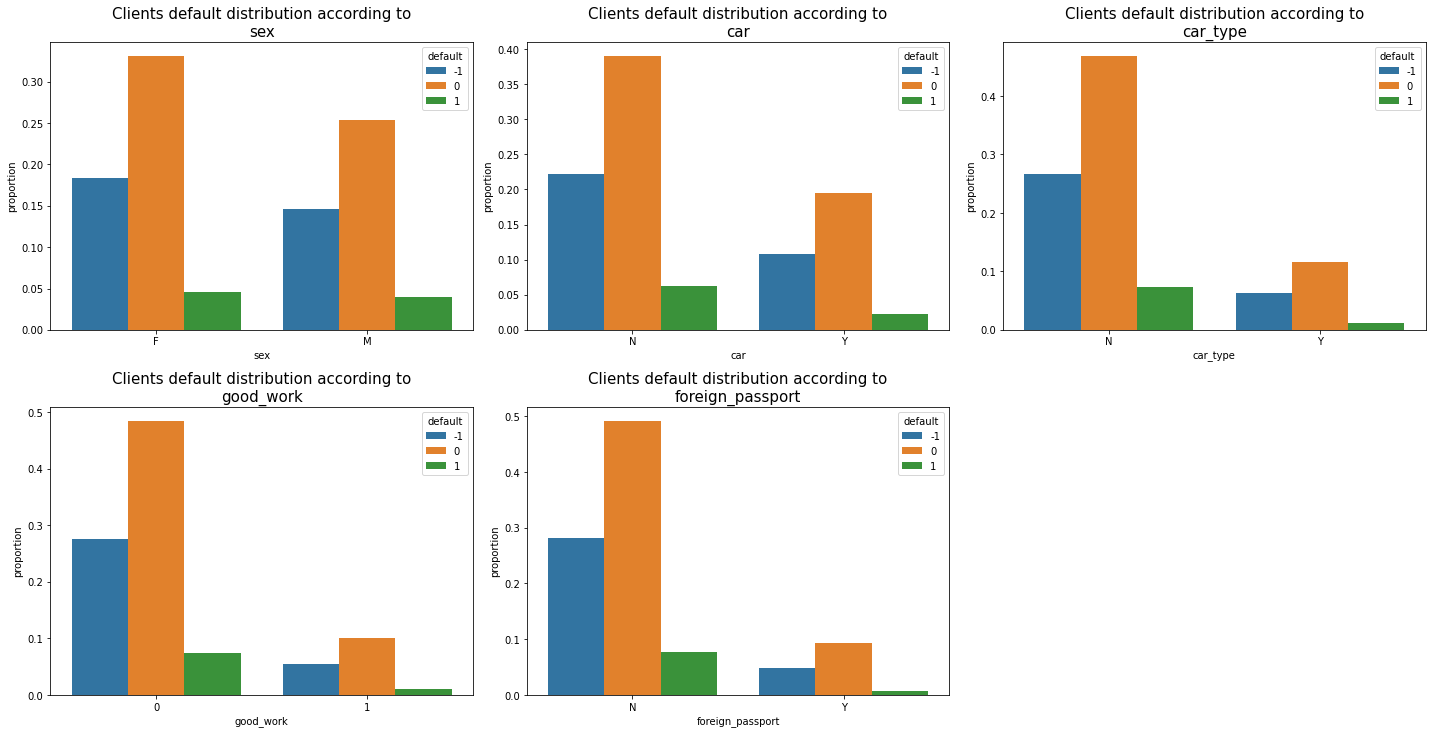

In [21]:
# посмотрим на распределение дефолтных состояний по различным признакам

plt.figure(figsize=[20, 20])
i = 1

for k in bin_cols:
    plt.subplot(4, 3, i)
    sns.barplot(
        x=k,
        y='proportion',
        hue='default',
        data=data[[k, 'default']].value_counts(normalize=True).rename('proportion').reset_index()
    )
    plt.title('Clients default distribution according to\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [22]:
# закодируем бинарные признаки

mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))
    
print(mapp)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}


## Корреляционный анализ

Существенная корреляция между домашним адресом и местом работы. Можно попробовать удалить один из признаков.

Сильная корреляция между car, car_type. Отсутствие автомобиля и соответственное отсутствие признака, что автомобиль иностранный. Далее скомбинируем два столбца в один, преобразовав в новый категориальный признак. Так мы уменьшим размерность набора данных, но не потеряем информацию.

Есть довольно сильная обратная зависимость между sna, first_time. Объяснить эти признаки можно попробовать так: чем дольше человек является клиентом банка, тем больше у него отношений с другими клиентами внутри банка (например, поручители) и тем ниже риск дефолта.

Наиболее статистически значимые признаки - Score_bki, decline_app_cnt. Мультиколлинеарность в целом отсутствует, что подтверждается рангом матрицы. Значение определителя позволяет сделать предположение о наличиии обратной матрицы.

<AxesSubplot:title={'center':'Correlation Matrix of dataset features'}>

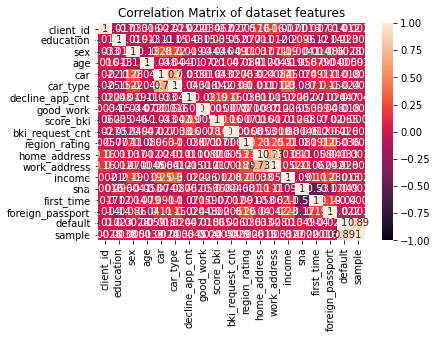

In [23]:
plt.title('Correlation Matrix of dataset features')
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot = True)

<AxesSubplot:title={'center':'Correlation Matrix of dataset features (numerical)'}>

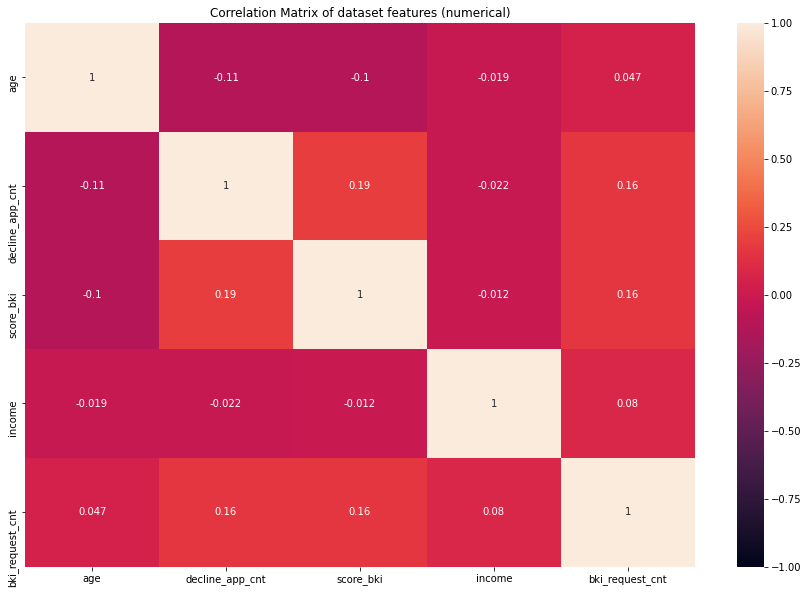

In [24]:
plt.title('Correlation Matrix of dataset features (numerical)')
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1, annot = True)

<AxesSubplot:title={'center':'Correlation Matrix of dataset features (categorical)'}>

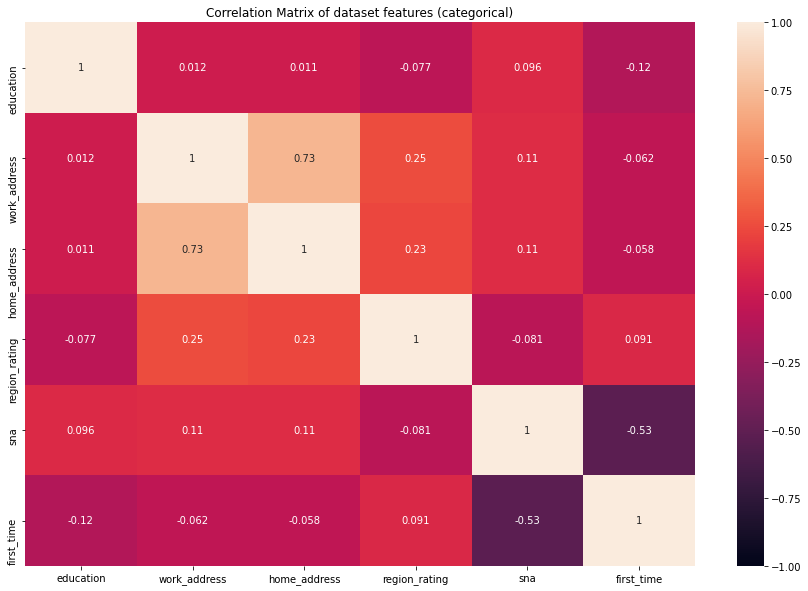

In [25]:
plt.title('Correlation Matrix of dataset features (categorical)')
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[cat_cols].corr(), vmin=-1, vmax=1, annot = True)

<AxesSubplot:title={'center':'Correlation Matrix of dataset features (binary)'}>

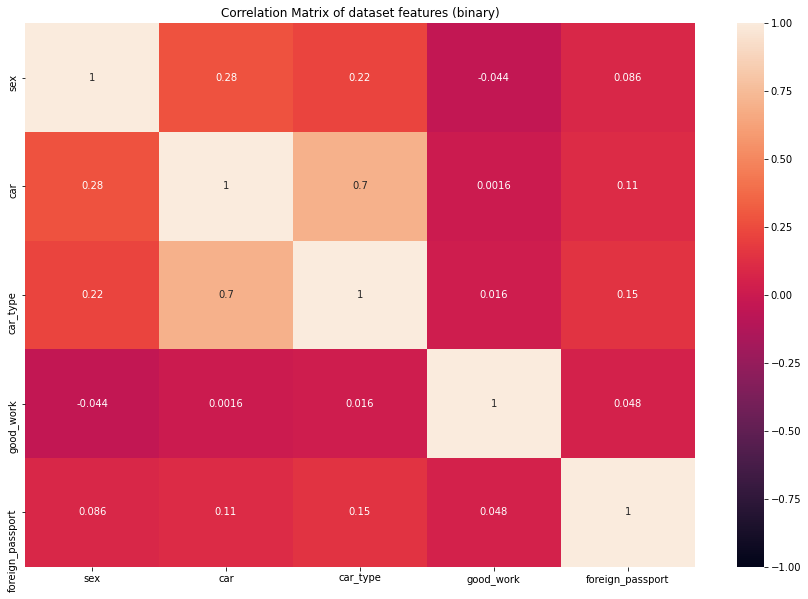

In [26]:
plt.title('Correlation Matrix of dataset features (binary)')
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[bin_cols].corr(), vmin=-1, vmax=1, annot = True)

## Наивная модель

Ожидаемо, результаты простых классификаторов (LogisticRegression, DecisionTreeClassifier, ExtraTreeClassifier) оказалось значительно хуже (ROC AUC в пределах 0.54-0.55), чем результаты ансамблей и специализированных моделей (результаты ROC_AUC в пределах 0.63-0.73 для AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), RandomForestClassifier(), CatBoostClassifier()).

Вернемся к тестированию качества моделей после генерации новых признаков и исключения признаков, обладающих высокой парной корреляцией.

In [27]:
# временно удалим столбец,
# вернемся к его обработке при создании новых признаков
df = data.drop(['app_date'], axis=1)

In [28]:
show_basic_models(df)

Results for: LogisticRegression(max_iter=1000)
accuracy_score:		 0.8762
precision_score:	 0.0
recall_score:		 0.0
f1_score:		 0.0
roc_auc_score:		 0.5517
---------

Results for: DecisionTreeClassifier()
accuracy_score:		 0.7862
precision_score:	 0.1945
recall_score:		 0.2315
f1_score:		 0.2114
roc_auc_score:		 0.548
---------

Results for: ExtraTreeClassifier()
accuracy_score:		 0.7906
precision_score:	 0.1911
recall_score:		 0.214
f1_score:		 0.2019
roc_auc_score:		 0.543
---------

Results for: AdaBoostClassifier()
accuracy_score:		 0.8753
precision_score:	 0.4426
recall_score:		 0.02956
f1_score:		 0.05541
roc_auc_score:		 0.7357
---------

Results for: BaggingClassifier()
accuracy_score:		 0.8664
precision_score:	 0.321
recall_score:		 0.07115
f1_score:		 0.1165
roc_auc_score:		 0.6304
---------

Results for: ExtraTreesClassifier()
accuracy_score:		 0.8696
precision_score:	 0.3225
recall_score:		 0.04871
f1_score:		 0.08464
roc_auc_score:		 0.6832
---------

Results for: GradientBo

## Создание признаков

### Декомпозиция адресов

Как мы установили ранее, home_address and work address обладают сильной корреляцией. Уменьшим размерность матрицы признаков с помощью sklearn.decomposition.

In [29]:
# получим кол-во дней от "начала эпохи" датасета
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
data_min = min(data['app_date'])
data['days'] = (data['app_date'] - data_min).dt.days.astype('int')
data['day'] = data['app_date'].dt.day
data['month'] = data['app_date'].dt.month

data.drop(['app_date'],  axis = 1, inplace = True)

# средний доход для конкретного возраста
mean_income = data.groupby('age')['income'].mean().to_dict()
data['mean_income_age'] = data['age'].map(mean_income)

# максимальный доход для конкретного возраста
max_income = data.groupby('age')['income'].max().to_dict()
data['max_income_age'] = data['age'].map(max_income)

# минимальный доход для конкретного возраста
min_income = data.groupby('age')['income'].min().to_dict()
data['min_income_age'] = data['age'].map(min_income)

# нормализуем доход
data["normalized_income"] = abs((data.income - data.mean_income_age)/data.max_income_age)
data.drop(['mean_income_age', 'max_income_age'],  axis = 1, inplace = True)

# среднее кол-во запросов в БКИ по конкретному возрасту
mean_bki = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_requests_age'] = data['age'].map(mean_bki)

# максимальное кол-во запросов в БКИ по конкретному возрасту
max_bki = data.groupby('age')['bki_request_cnt'].max().to_dict()
data['max_requests_age'] = data['age'].map(max_bki)

# нормализуем requests
data["normalized_req"] = abs((data.bki_request_cnt - data.mean_requests_age)/data.max_requests_age)
data.drop(['mean_requests_age', 'max_requests_age'],  axis = 1, inplace = True)

# среднее кол-во запросов в БКИ в зависимости от дохода
mean_bki_inc = data.groupby('income')['bki_request_cnt'].mean().to_dict()
data['mean_requests_income'] = data['income'].map(mean_bki_inc)

# средний доход по региону
mean_income_rat = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_rat)

data.drop(['income'],  axis = 1, inplace = True)

# сократим размерность матрицы без потери информации
# 0 - нет машины, 1 - есть отечественна машина, 2 - есть иномарка
data['car_comb'] = data['car'] + data['car_type']
data['car_comb'] = data['car_comb'].astype('category')
data.drop(['car', 'car_type'], axis=1, inplace=True)

# возраст разделим на четыре категории
data['age_cat'] = 0 # создадим пустой столбец для нового признака
data['age_cat'] = data['age'].apply(lambda x: age_to_cat(x))
data.drop('age', axis=1, inplace=True)

label_encoder = LabelEncoder()
data['age_cat'] = label_encoder.fit_transform(data['age_cat'])
    
# Sort out decline_app_cnt and bki_request_cnt by groups:
data['decline_cat'] = data['decline_app_cnt'].apply(lambda x: 4 if x >= 4 else x) 
data['bki_request_cat'] = data['bki_request_cnt'].apply(lambda x: 6 if x >= 6 else x)
data.drop(['decline_app_cnt', 'bki_request_cnt'], axis=1, inplace=True)

# Декомпозиция адресов

# вытащим два столбца из датасета
data_addresses = data[['work_address', 'home_address']].values

# создадим Scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_addresses)

# У нас два вектора. Сократим до одного, оставив наиболее значимую информацию.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
data['pca_address'] = pca_data
data['pca_address'] = data['pca_address'] + 5
data['pca_address'] = data['pca_address'].apply(lambda x: np.log(x) + 1)

# удалим ненужные столбцы
data.drop(['home_address','work_address'], axis=1, inplace=True)

# fix 2 zeros in normalized_req
data = data.fillna(data.mean())

In [30]:
# обновим списки признаков в переменных для обработки
# exclude day, month (high correlation)
num_cols = [
    'score_bki',
    'days',
    'min_income_age',
    'normalized_income',
    'normalized_req',
    'mean_requests_income',
    'mean_income_region',
]
cat_cols = [
    'education',
    'region_rating',
    'sna',
    'first_time',
    'car_comb',
    'age_cat',
    'decline_cat',
    'bki_request_cat',
    'pca_address',
]
bin_cols = [
    'sex',
    'good_work',
    'foreign_passport',
]

## Выбросы и стандартизация

In [31]:
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    
    print("Column: ", col)
    print(' 25%: {:.4},\n'.format(perc25), '75%: {:.4},\n'.format(perc75),
          "IQR: {:.4}, \n".format(IQR), "Borderline: [{f:.4}, {l:.4}].\n".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()
    
    # replace outliers with border-values
    data[col] = np.where(data[col] > (perc75 + 1.5*IQR), (perc75 + 1.5*IQR), data[col])
    data[col] = np.where(data[col] < (perc25 - 1.5*IQR), (perc25 - 1.5*IQR), data[col])

Column:  score_bki
 25%: -2.26,
 75%: -1.568,
 IQR: 0.6925, 
 Borderline: [-3.299, -0.5291].


Column:  days
 25%: 33.0,
 75%: 89.0,
 IQR: 56.0, 
 Borderline: [-51.0, 173.0].


Column:  min_income_age
 25%: 2.4e+03,
 75%: 5e+03,
 IQR: 2.6e+03, 
 Borderline: [-1.5e+03, 8.9e+03].


Column:  normalized_income
 25%: 0.0118,
 75%: 0.03443,
 IQR: 0.02263, 
 Borderline: [-0.02214, 0.06837].


Column:  normalized_req
 25%: 0.02792,
 75%: 0.07704,
 IQR: 0.04913, 
 Borderline: [-0.04578, 0.1507].


Column:  mean_requests_income
 25%: 1.857,
 75%: 2.113,
 IQR: 0.256, 
 Borderline: [1.473, 2.497].


Column:  mean_income_region
 25%: 3.504e+04,
 75%: 3.729e+04,
 IQR: 2.252e+03, 
 Borderline: [3.166e+04, 4.067e+04].




In [32]:
scaler = RobustScaler()
data[num_cols] = scaler.fit_transform(data[num_cols].values)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   client_id             110148 non-null  int64   
 1   education             110148 non-null  int64   
 2   sex                   110148 non-null  int64   
 3   good_work             110148 non-null  int64   
 4   score_bki             110148 non-null  float64 
 5   region_rating         110148 non-null  int64   
 6   sna                   110148 non-null  int64   
 7   first_time            110148 non-null  int64   
 8   foreign_passport      110148 non-null  int64   
 9   default               110148 non-null  int64   
 10  sample                110148 non-null  int64   
 11  days                  110148 non-null  float64 
 12  day                   110148 non-null  int64   
 13  month                 110148 non-null  int64   
 14  min_income_age        110148 non-nul

In [34]:
data.head()

,client_id,education,sex,good_work,score_bki,region_rating,sna,first_time,foreign_passport,default,sample,days,day,month,min_income_age,normalized_income,normalized_req,mean_requests_income,mean_income_region,car_comb,age_cat,decline_cat,bki_request_cat,pca_address
0,25905,3,1,0,-0.126966,3,3,0,0,0,1,-0.553571,1,2,0.384615,0.501385,-0.005292,0.113965,0.0,2,3,0,1,2.313032
1,63161,3,0,0,0.561041,3,3,0,0,0,1,0.142857,12,3,-0.769231,-0.473116,-0.154848,0.770963,0.0,0,3,0,3,2.806001
2,25887,3,1,0,0.740284,6,0,3,1,0,1,-0.553571,1,2,-1.153846,-0.544412,-0.331699,-0.313126,2.5,1,0,2,1,2.313032
3,16222,3,0,0,-0.197313,3,0,2,0,0,1,-0.714286,23,1,0.384615,0.482167,-0.748451,-1.754185,0.0,0,3,0,2,2.806001
4,101655,1,1,1,0.976254,4,0,3,1,0,1,0.803571,18,4,0.384615,-0.182436,-0.220505,-0.313126,1.0,0,2,0,1,2.806001


## Моделирование после добавления признаков

Настройка моделей еще не проведена, использовались стандартные настройки.

Результаты по ROC AUC для DecisionTreeClassifier, ExtraTreeClassifier остались на прежнем уровне в 0.54

В то же время, метрика LogisticRegression увеличена с 0.55 до 0.739.

Лучший результат после добавления новых признаков у GradientBoostingClassifier - 0.7418.

Метрики AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(), RandomForestClassifier(), CatBoostClassifier() - в диапазоне 0.65-0.73.

Вернемся к тестированию качества моделей после One-Hot Encoding категориальных признаков и исключения попарно коррелирующихся признаков.

In [35]:
show_basic_models(data)

Results for: LogisticRegression(max_iter=1000)
accuracy_score:		 0.8745
precision_score:	 0.3711
recall_score:		 0.0197
f1_score:		 0.03742
roc_auc_score:		 0.7392
---------

Results for: DecisionTreeClassifier()
accuracy_score:		 0.7856
precision_score:	 0.1856
recall_score:		 0.2162
f1_score:		 0.1997
roc_auc_score:		 0.5411
---------

Results for: ExtraTreeClassifier()
accuracy_score:		 0.7954
precision_score:	 0.1879
recall_score:		 0.1965
f1_score:		 0.1921
roc_auc_score:		 0.5382
---------

Results for: AdaBoostClassifier()
accuracy_score:		 0.8744
precision_score:	 0.3884
recall_score:		 0.02573
f1_score:		 0.04825
roc_auc_score:		 0.7397
---------

Results for: BaggingClassifier()
accuracy_score:		 0.8678
precision_score:	 0.3133
recall_score:		 0.05692
f1_score:		 0.09634
roc_auc_score:		 0.6544
---------

Results for: ExtraTreesClassifier()
accuracy_score:		 0.8756
precision_score:	 0.4366
recall_score:		 0.01697
f1_score:		 0.03267
roc_auc_score:		 0.7082
---------

Results 

## One-Hot Encoding для категориальных признаков

In [36]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 63 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   client_id                       110148 non-null  int64  
 1   sex                             110148 non-null  int64  
 2   good_work                       110148 non-null  int64  
 3   score_bki                       110148 non-null  float64
 4   foreign_passport                110148 non-null  int64  
 5   default                         110148 non-null  int64  
 6   sample                          110148 non-null  int64  
 7   days                            110148 non-null  float64
 8   day                             110148 non-null  int64  
 9   month                           110148 non-null  int64  
 10  min_income_age                  110148 non-null  float64
 11  normalized_income               110148 non-null  float64
 12  normalized_req  

### Корреляционный анализ после генерации новых признаков

<AxesSubplot:title={'center':'Correlation Matrix of dataset features'}>

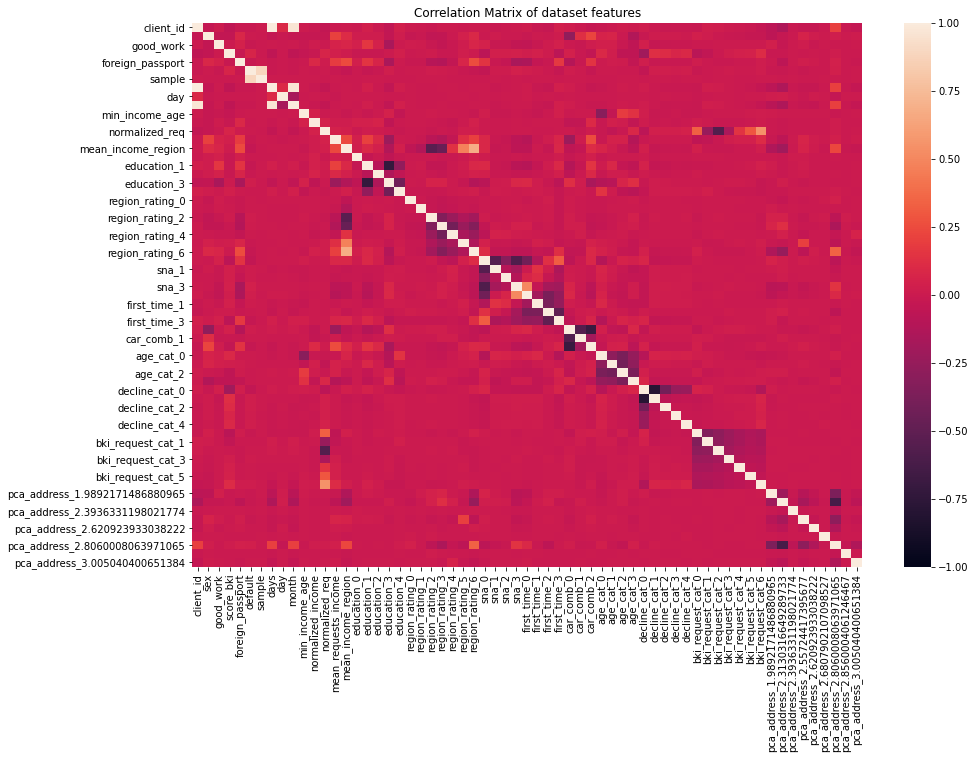

In [38]:
plt.title('Correlation Matrix of dataset features')
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot = False)

In [39]:
# show features with corr > 0.7
corr = data.corr().abs()
corr_table = corr.unstack()
corr_table_sorted = corr_table.sort_values(kind="quicksort", ascending=False)
corr_exclude_ones = corr_table_sorted[corr_table_sorted != 1]
high_corr = corr_exclude_ones[corr_exclude_ones >= 0.7]
high_corr

client_id      days             0.999581
days           client_id        0.999581
month          client_id        0.967146
client_id      month            0.967146
month          days             0.964939
days           month            0.964939
sample         default          0.889281
default        sample           0.889281
decline_cat_0  decline_cat_1    0.791793
decline_cat_1  decline_cat_0    0.791793
education_1    education_3      0.722475
education_3    education_1      0.722475
dtype: float64

In [40]:
# exclude features due high corr
data.drop(['day','month', 'region_rating_6', 'decline_cat_1', 'education_3'], axis=1, inplace=True)

## Моделирование после One-Hot Encoding

Настройка моделей еще не проведена, использовались стандартные настройки.

Результаты по ROC AUC для DecisionTreeClassifier, ExtraTreeClassifier остались на прежнем уровне в 0.53-0.54

В то же время, метрика LogisticRegression увеличена с 0.739 до 0.746 (теперь это лучшая модель).

Также, метрика выше 0.74 у GradientBoostingClassifier и AdaBoostClassifier.

Метрики BaggingClassifier(), ExtraTreesClassifier(), RandomForestClassifier(), CatBoostClassifier() - в диапазоне 0.65-0.73.

Вернемся к тестированию качества моделей после оценки статистической значимости признаков и исключения малозначимых фич.

In [41]:
show_basic_models(data)

Results for: LogisticRegression(max_iter=1000)
accuracy_score:		 0.8752
precision_score:	 0.4211
recall_score:		 0.02189
f1_score:		 0.04162
roc_auc_score:		 0.7463
---------

Results for: DecisionTreeClassifier()
accuracy_score:		 0.7886
precision_score:	 0.201
recall_score:		 0.2381
f1_score:		 0.218
roc_auc_score:		 0.5522
---------

Results for: ExtraTreeClassifier()
accuracy_score:		 0.7945
precision_score:	 0.1979
recall_score:		 0.2162
f1_score:		 0.2066
roc_auc_score:		 0.5462
---------

Results for: AdaBoostClassifier()
accuracy_score:		 0.8749
precision_score:	 0.402
recall_score:		 0.02244
f1_score:		 0.04251
roc_auc_score:		 0.7409
---------

Results for: BaggingClassifier()
accuracy_score:		 0.868
precision_score:	 0.3007
recall_score:		 0.05036
f1_score:		 0.08626
roc_auc_score:		 0.654
---------

Results for: ExtraTreesClassifier()
accuracy_score:		 0.8727
precision_score:	 0.3471
recall_score:		 0.03229
f1_score:		 0.05909
roc_auc_score:		 0.6955
---------

Results for:

## Статистическая значимость признаков

In [42]:
data_temp = data.loc[data['sample'] == 1].drop(['client_id','sample'], axis=1)

<AxesSubplot:title={'center':'Numeric Features Importance'}>

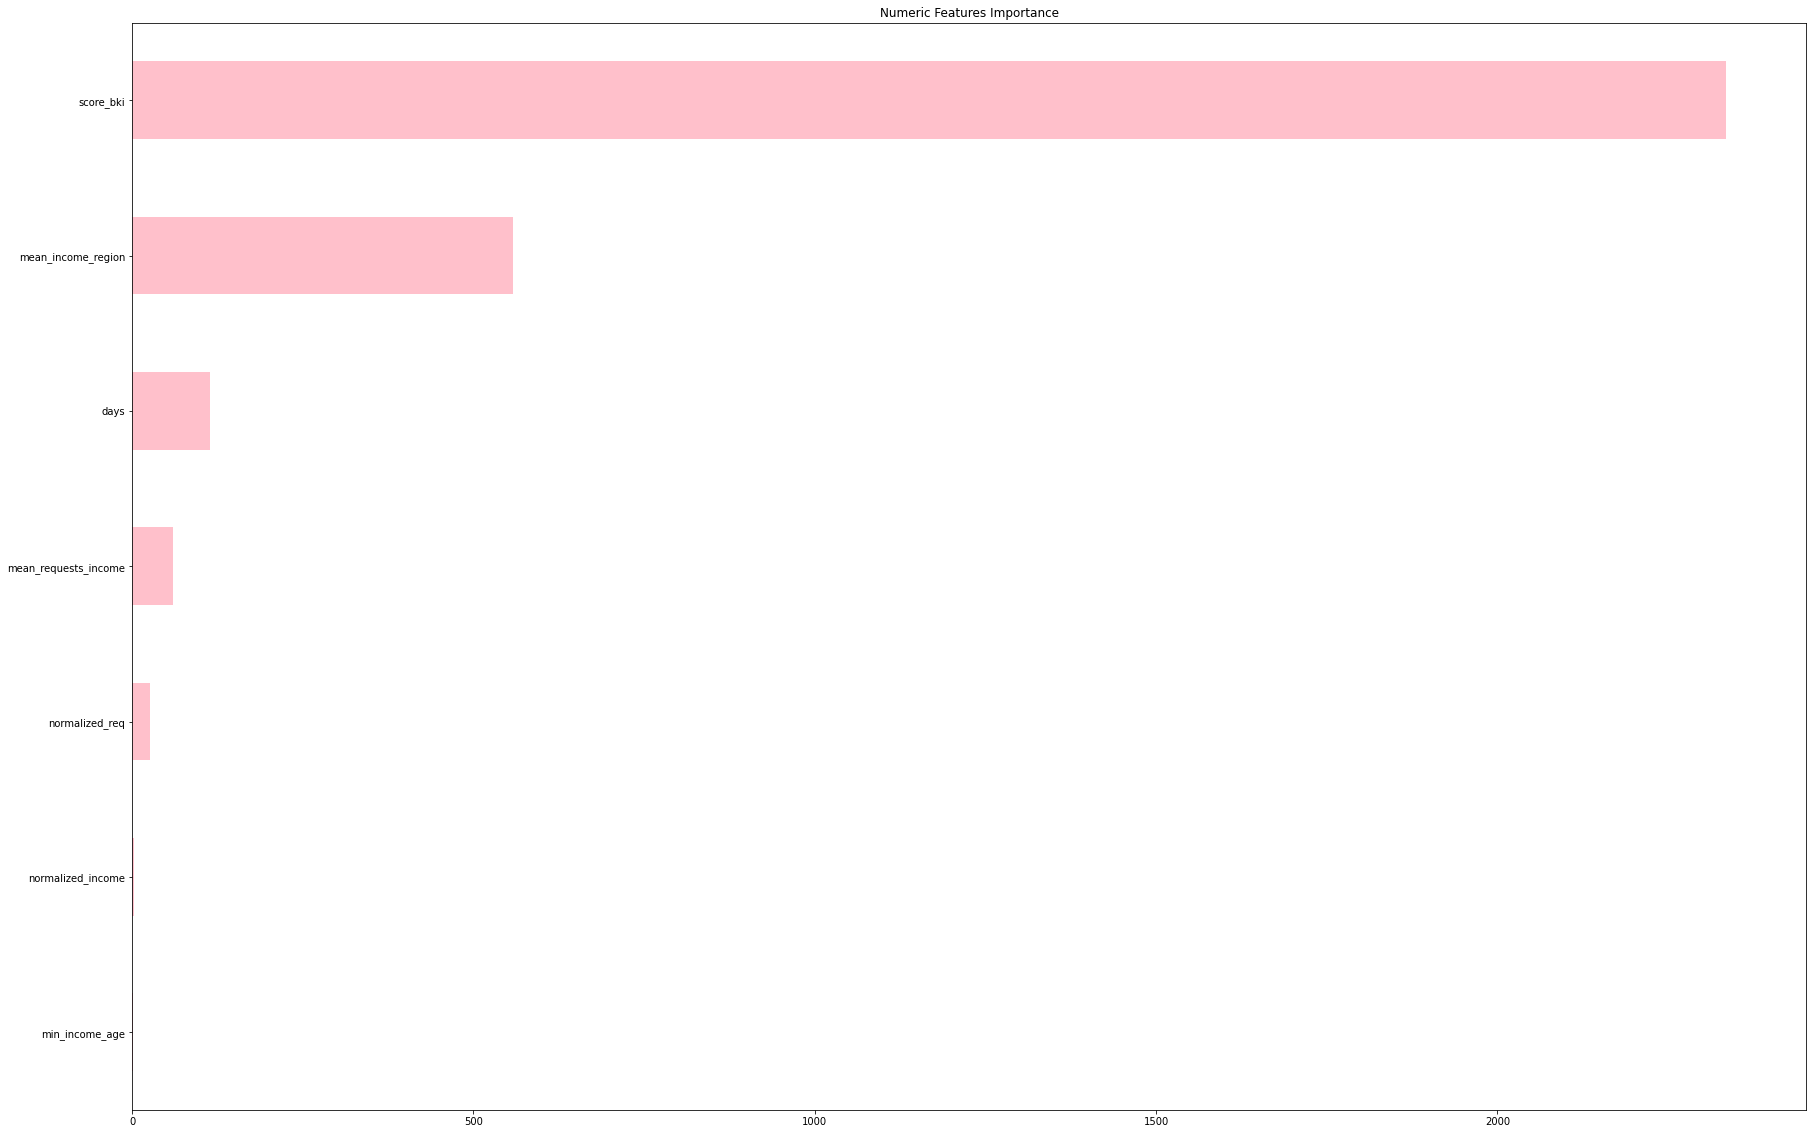

In [43]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh', color='pink', title='Numeric Features Importance')

In [44]:
imp_num

min_income_age             0.697757
normalized_income          3.253724
normalized_req            26.362753
mean_requests_income      60.038451
days                     114.576824
mean_income_region       558.589340
score_bki               2335.659828
dtype: float64

<AxesSubplot:title={'center':'Binary Features Importance'}>

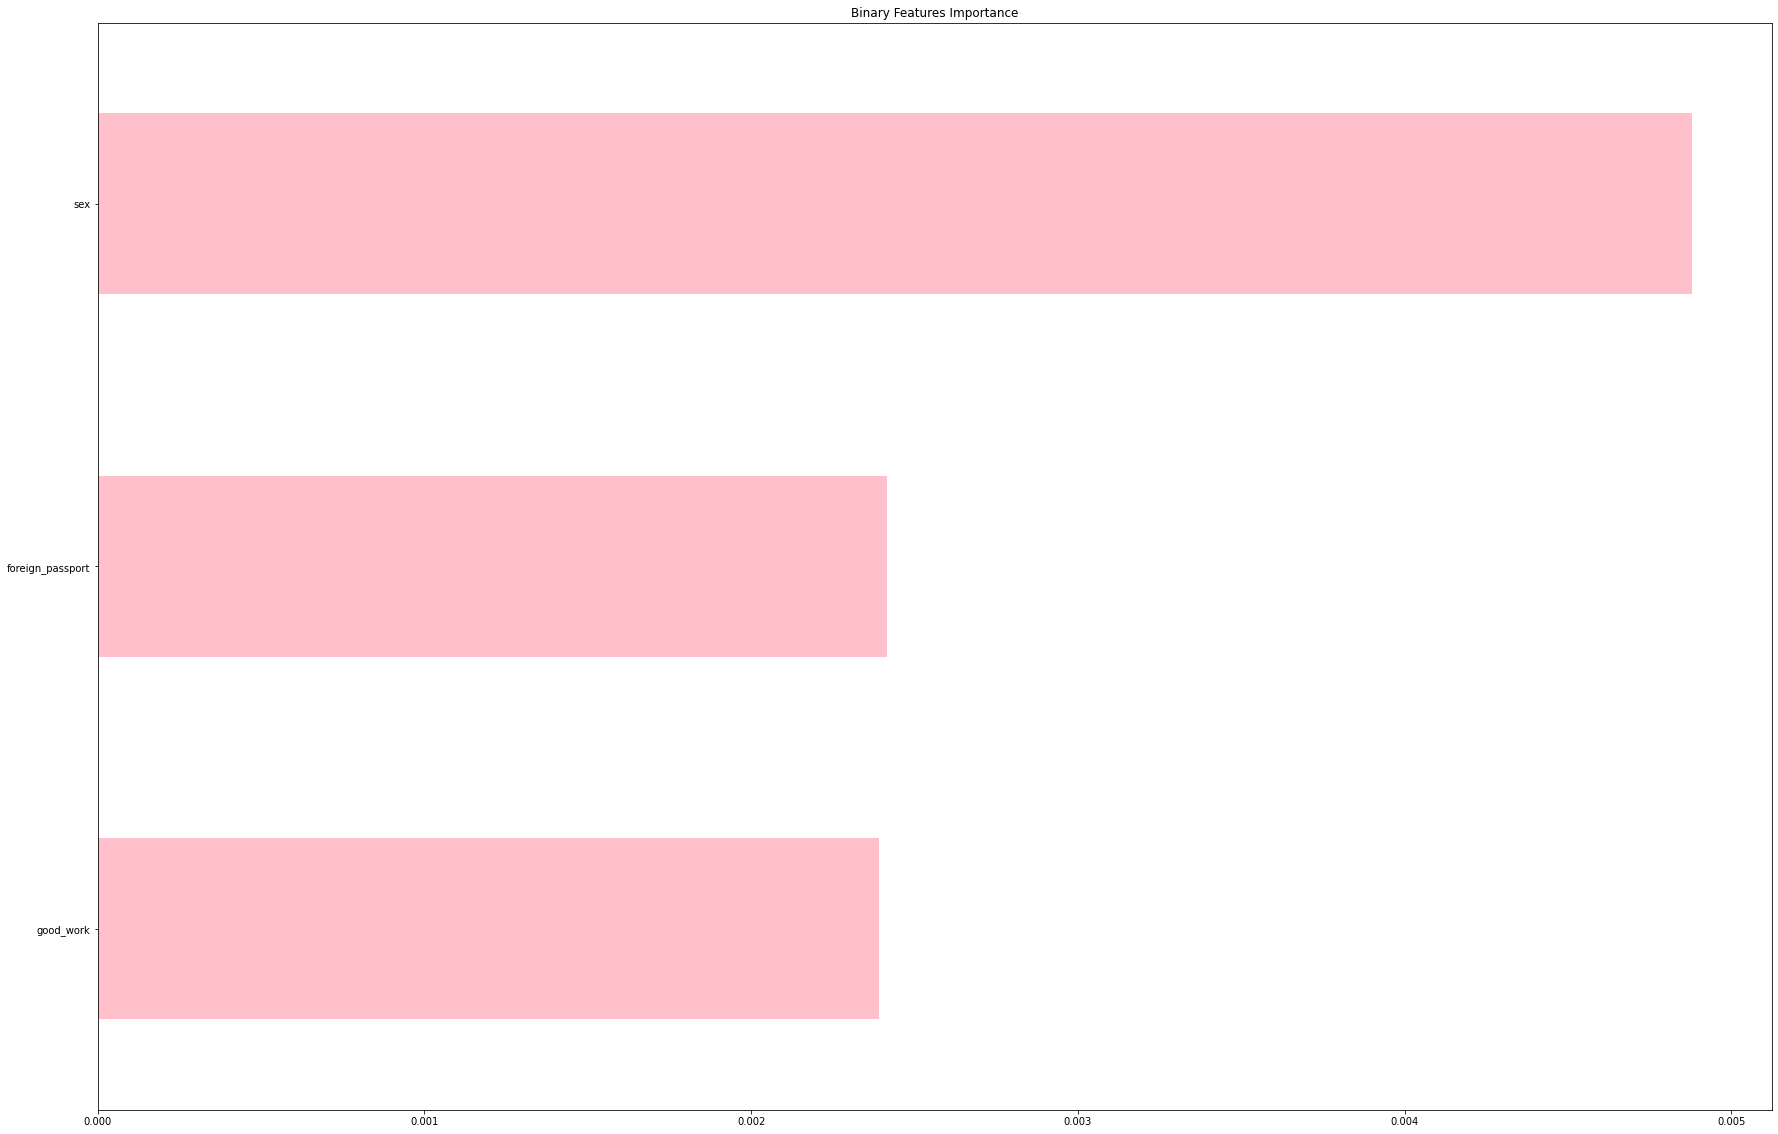

In [45]:
imp_bin = pd.Series(mutual_info_classif(
    data_temp[bin_cols],
    data_temp['default'],
    discrete_features=False
), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh', color='pink', title='Binary Features Importance')

In [46]:
imp_bin

good_work           0.002392
foreign_passport    0.002416
sex                 0.004879
dtype: float64

<AxesSubplot:title={'center':'Categorical Features Importance'}>

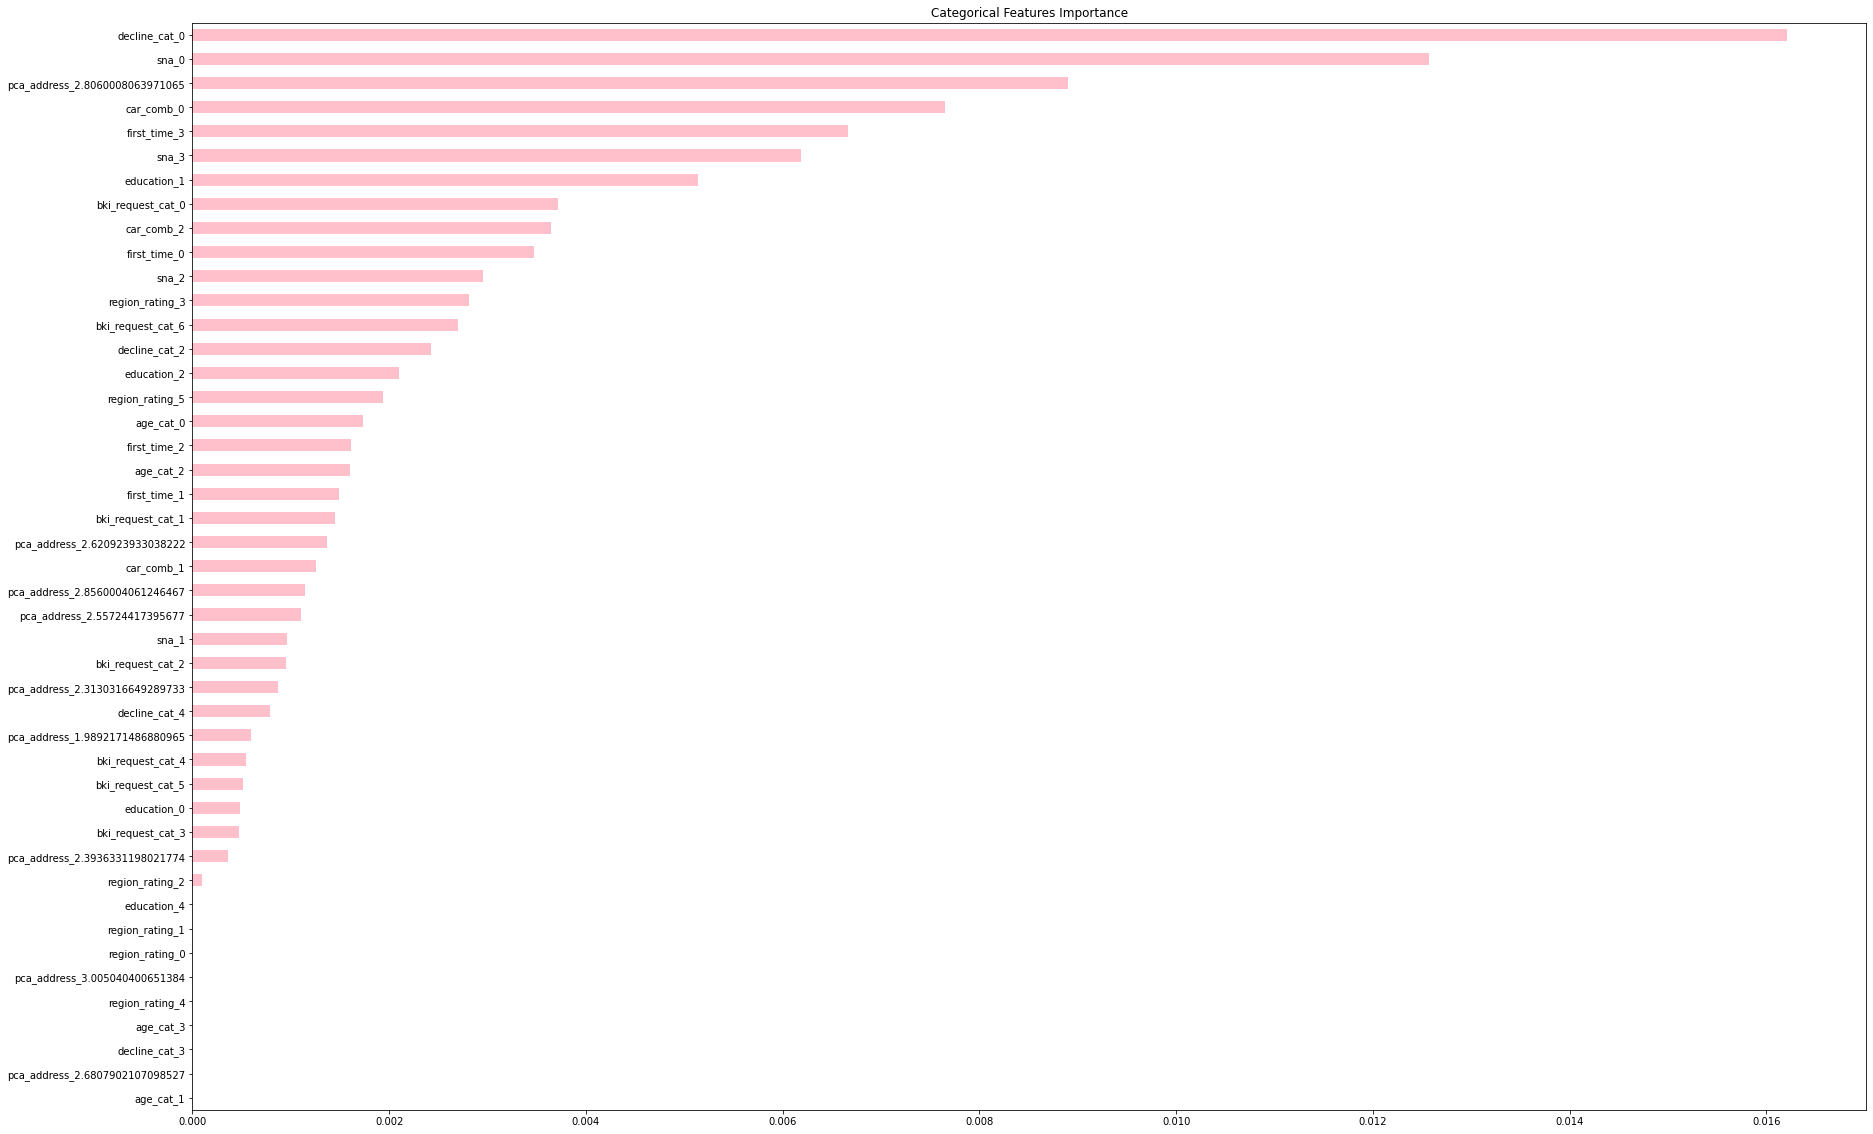

In [47]:
# update cat_cols list of columns
cols = list(data.columns)
num_bin_cols = [col for col in cols if (col in bin_cols or col in num_cols)]
cat_cols = [col for col in cols if col not in num_bin_cols]
cat_cols.remove('client_id')
cat_cols.remove( 'default')
cat_cols.remove('sample')

imp_cat = pd.Series(mutual_info_classif(
    data_temp[cat_cols],
    data_temp['default'],
    discrete_features=False
), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', color='pink', title='Categorical Features Importance')

In [48]:
imp_cat

age_cat_1                         0.000000
pca_address_2.6807902107098527    0.000000
decline_cat_3                     0.000000
age_cat_3                         0.000000
region_rating_4                   0.000000
pca_address_3.005040400651384     0.000000
region_rating_0                   0.000000
region_rating_1                   0.000000
education_4                       0.000000
region_rating_2                   0.000102
pca_address_2.3936331198021774    0.000359
bki_request_cat_3                 0.000474
education_0                       0.000486
bki_request_cat_5                 0.000520
bki_request_cat_4                 0.000546
pca_address_1.9892171486880965    0.000596
decline_cat_4                     0.000787
pca_address_2.3130316649289733    0.000870
bki_request_cat_2                 0.000955
sna_1                             0.000967
pca_address_2.55724417395677      0.001100
pca_address_2.8560004061246467    0.001143
car_comb_1                        0.001261
pca_address

## Моделирование после исключения малозначимых признаков

После исключения малозначимых признаков по-прежнему лучшие метрики ROC AUC показывает LogisticRegression (0.746), далее следуют GradientBoostingClassifier (0.743) и AdaBoostClassifier (0.740). Остальные модели демонстрируют метрику ниже 0.74.

За базовую возьмем LogisticRegression и будем настраивать гиперпараметры этого варианта классификатора.

In [49]:
cat_cols_to_drop = list(imp_cat[imp_cat==0].index)
data.drop(cat_cols_to_drop, axis=1, inplace=True)

In [50]:
show_basic_models(data)

Results for: LogisticRegression(max_iter=1000)
accuracy_score:		 0.875
precision_score:	 0.4151
recall_score:		 0.02408
f1_score:		 0.04553
roc_auc_score:		 0.7449
---------

Results for: DecisionTreeClassifier()
accuracy_score:		 0.793
precision_score:	 0.2075
recall_score:		 0.2386
f1_score:		 0.222
roc_auc_score:		 0.555
---------

Results for: ExtraTreeClassifier()
accuracy_score:		 0.7942
precision_score:	 0.1931
recall_score:		 0.2085
f1_score:		 0.2005
roc_auc_score:		 0.5427
---------

Results for: AdaBoostClassifier()
accuracy_score:		 0.8745
precision_score:	 0.3894
recall_score:		 0.02408
f1_score:		 0.04536
roc_auc_score:		 0.7398
---------

Results for: BaggingClassifier()
accuracy_score:		 0.8699
precision_score:	 0.3601
recall_score:		 0.06623
f1_score:		 0.1119
roc_auc_score:		 0.6546
---------

Results for: ExtraTreesClassifier()
accuracy_score:		 0.8724
precision_score:	 0.3208
recall_score:		 0.02791
f1_score:		 0.05136
roc_auc_score:		 0.6958
---------

Results for:

## Промежуточные выводы

Бинарные признаки:
* Car и car_type сильно взаимозависимы. Объединены в один признак car_comb с тремя характеристиками.
* Количество должников среди мужчин и женщин примерно одинаковое, но женщины берут кредиты чаще.

Категориальные признаки:
* Люди со слабым образованием возвращают кредиты реже, чем люди с сильным образованием.
* Чем больше отношений у клиента с другими клиентами в банке - тем лучше и меньше просроченных кредитов.
* Люди с более крутым образованием живут в регионах с более высоким рейтингом.
* Чем выше рейтинг региона, тем ниже риск дефолта.
* Имеется корреляция между sna и first_time, Home и work addresses (признак заменен на объединенный посредством PCA).

Numerical:
* score_bki имеет распределение, близкое к нормальному
* В данных есть выбросы. Устранены через преобразование признаков в категориальные, логарифмирование или с использованием Scaler
* Между количественными признаками нет сильных корреляций
* Наличие иномарки коррелирует с уровнем дохода
* Количество связей с другими клиентами банка коррелирует с наличием заграничного паспорта

Наиболее статистически значимые признаки:
* sna
* pca_address (home & work addresses)
* first_time
* score_bki
* mean_income_region

Поскольку мы имеем достаточно много неочевидных корреляций между признаками, стоит попробовать использовать logistic regressions (при этом descicion tree models показали довольно слабые результаты).

## Моделирование

Сравним logisticRegression со стандартными настройками и настройкой class_weight='balanced'.

In [51]:
train_df = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_df = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED)

In [52]:
# default model

lr = LogisticRegression(max_iter=500)
y_pred, probs = compute_selected_model(lr)

# 0.7451

accuracy_score:		 0.875
precision_score:	 0.4151
recall_score:		 0.02408
f1_score:		 0.04553
roc_auc_score:		 0.7449


In [53]:
# penalty=none is stronger than penalty=l2

lr_penalty_none = LogisticRegression(penalty='none', max_iter=1000)
y_pred, probs = compute_selected_model(lr_penalty_none)

# 0.7452

accuracy_score:		 0.875
precision_score:	 0.4151
recall_score:		 0.02408
f1_score:		 0.04553
roc_auc_score:		 0.7449


In [54]:
# multi_class=multinominal is weaker than auto or ovr (them equal)

lr_ovr = LogisticRegression(penalty='l2', max_iter=1000, multi_class='ovr')
y_pred, probs = compute_selected_model(lr_ovr)

# 0.7451

accuracy_score:		 0.875
precision_score:	 0.4151
recall_score:		 0.02408
f1_score:		 0.04553
roc_auc_score:		 0.7449


In [55]:
# higher max_iter - higher metrics (costs time)

lr_sag = LogisticRegression(penalty='l2', max_iter=1500, solver='sag')
y_pred, probs = compute_selected_model(lr_sag)

# 0.7451

accuracy_score:		 0.875
precision_score:	 0.4151
recall_score:		 0.02408
f1_score:		 0.04553
roc_auc_score:		 0.7449


In [56]:
# saga is weaker than sag with equal max_iter
# both sag and saga weaker than default solver

lr_saga = LogisticRegression(penalty='l2', max_iter=1500, solver='saga')
y_pred, probs = compute_selected_model(lr_saga)

# 0.7451

accuracy_score:		 0.875
precision_score:	 0.4151
recall_score:		 0.02408
f1_score:		 0.04553
roc_auc_score:		 0.7449


In [57]:
# balanced is weaker than default settings in roc_auc
# but f1_score is significant stronger

lr_balanced = LogisticRegression(class_weight='balanced', max_iter=500)
y_pred, probs = compute_selected_model(lr_balanced)

# 0.7444

accuracy_score:		 0.6691
precision_score:	 0.2268
recall_score:		 0.6946
f1_score:		 0.342
roc_auc_score:		 0.7442


### Краткие выводы по LogReg

1. Настройка сбалансированного веса классов ухудшает метрику ROC AUC по сравнению с настройками по умолчанию (f1_score, при этом, улучшается существенно).
2. Solvers sag, saga - слабее, чем solver по умолчанию (lbfgs).
3. На заданном наборе данных penalty=none эффективнее penalty=l2.
4. Мультикласс-настройка multinominal формирует более слабую модель. Ovr формирует идентичную модель с настройкой по умолчанию - auto.

## Оценка ROC AUC и других метрик

In [58]:
# best LogReg model from previous chapter with balanced class weights

lr_balanced_penalty_none = LogisticRegression(class_weight='balanced', penalty='none', max_iter=1000)
y_pred, probs = compute_selected_model(lr_balanced_penalty_none)

accuracy_score:		 0.6691
precision_score:	 0.2268
recall_score:		 0.6946
f1_score:		 0.342
roc_auc_score:		 0.7441


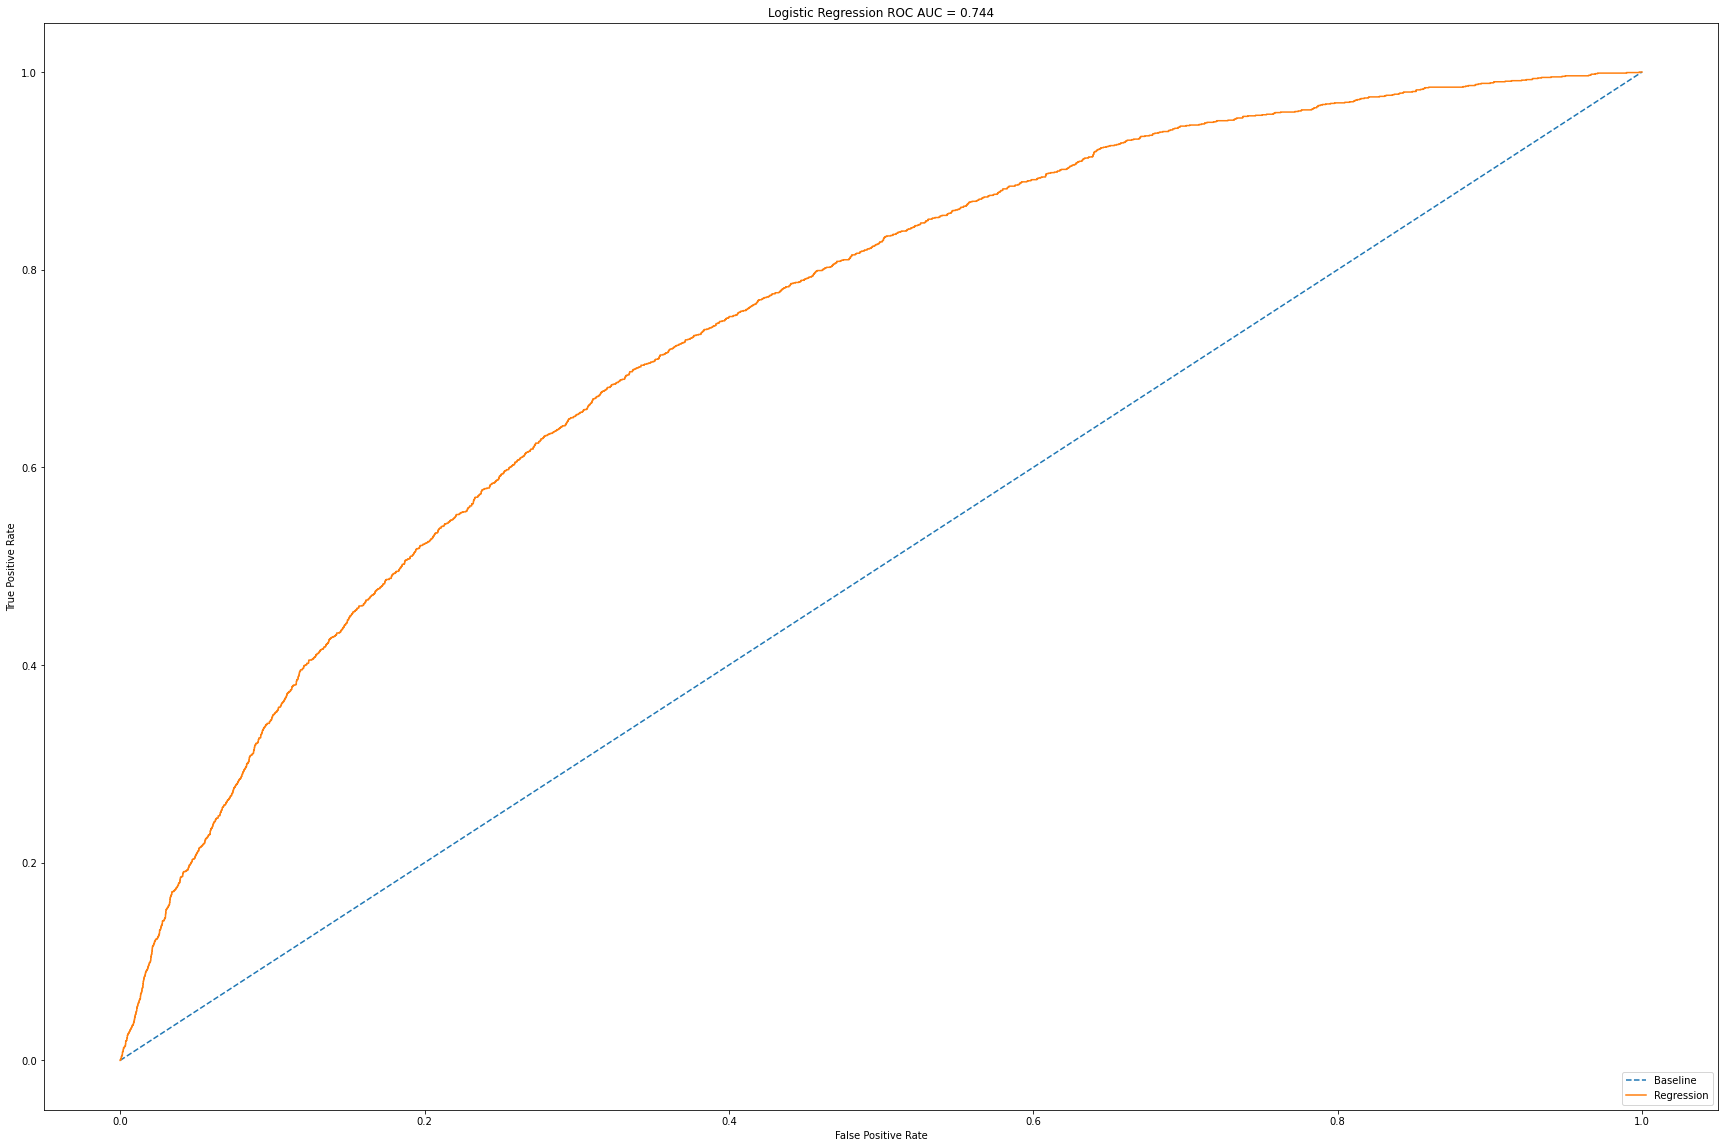

In [59]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

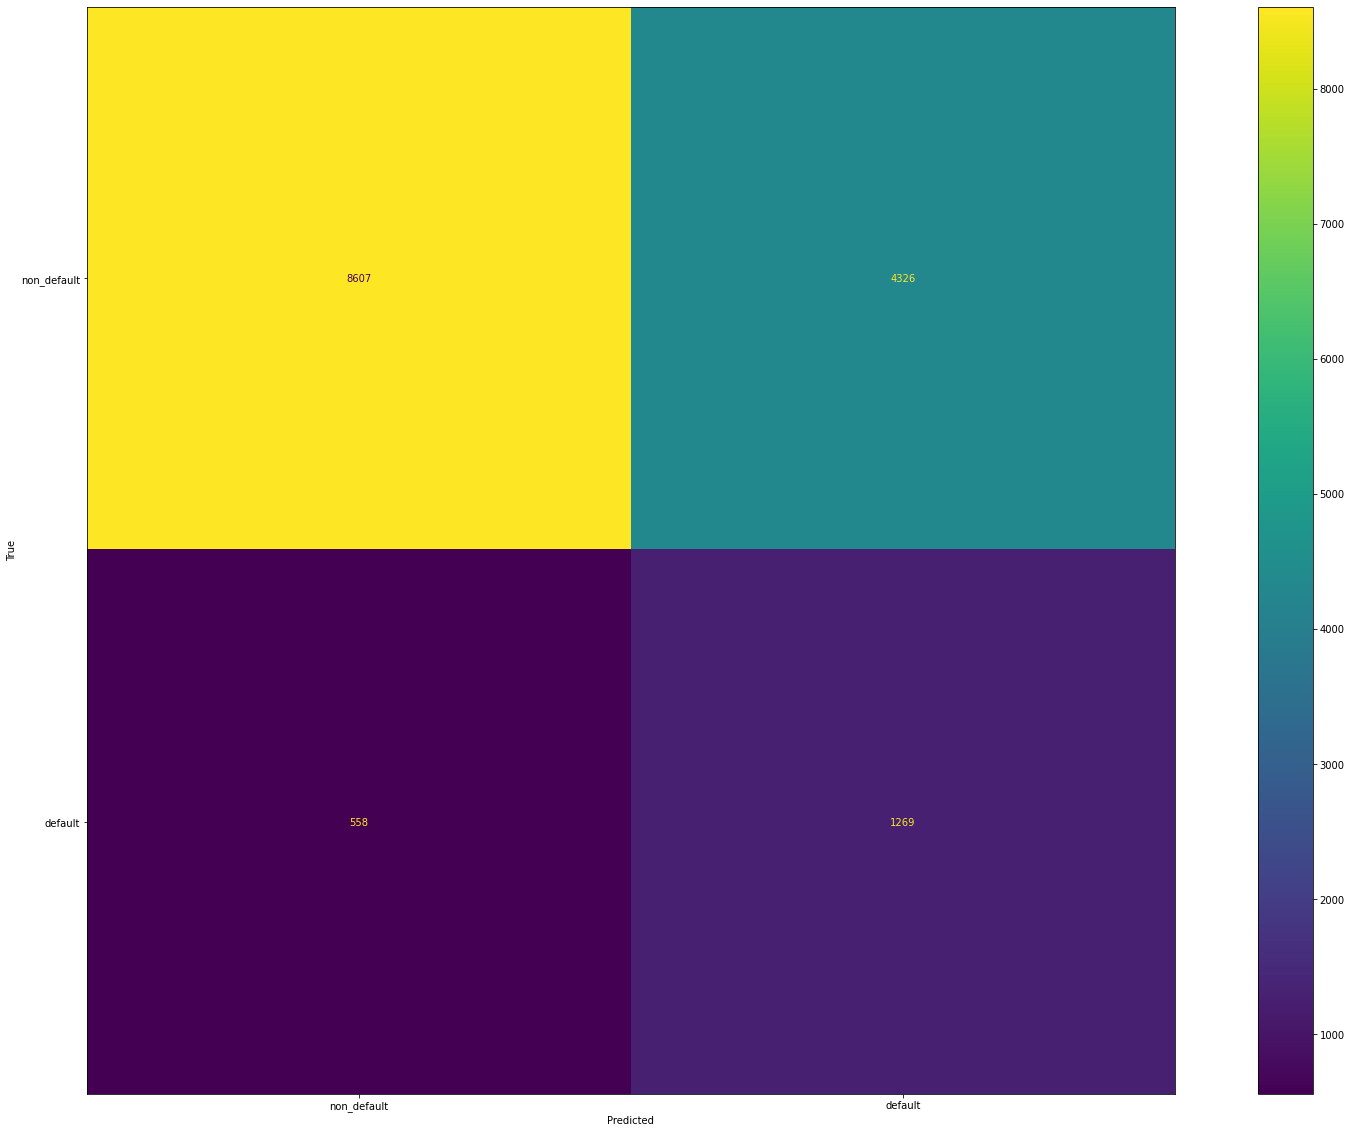

In [60]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default', 'default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

LogisticRegression на стандартных настройках имеет большцю ROC AUC, чем с настройкой class_weight=balanced. В то же время, f1_score выше у class_weight=balanced.

Были проведены эксперименты с различными классификаторами (XGBoost, GradientBoostingClassifier, AdaBoost - в ранних версиях каггл-ноутбуков), и, например, XGBoostClassifier с подбором параметров через RandomizedSearchCV давал более эффективные результаты по ROC AUC. тем не менее, в учебных целях и для чистоты эксперимента по сравниванию настроек по умолчанию и настроек, получаемых методами подбора гиперпараметров, осуществим эту работу для LogisticRegression.

## Подбор гиперпараметров

In [61]:
train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)
y_test = test_data.default.values

In [62]:
# Penalty - Used to specify the norm used in the penalization

# C - Inverse of regularization strength; 
# must be a positive float.
# Like in support vector machines, smaller values specify stronger regularization.

# solver - Algorithm to use in the optimization problem.
# UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'

params = {
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression(penalty='l2', max_iter=1000, class_weight='balanced', n_jobs=4)
model.fit(X_train, y_train)

clf = GridSearchCV(model, params, cv=5, verbose=3)

best_model = clf.fit(X_train, y_train)

print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END .........................C=0.0001, solver=lbfgs; total time=   1.5s
[CV 2/5] END .........................C=0.0001, solver=lbfgs; total time=   1.5s
[CV 3/5] END .........................C=0.0001, solver=lbfgs; total time=   1.4s
[CV 4/5] END .........................C=0.0001, solver=lbfgs; total time=   1.2s
[CV 5/5] END .........................C=0.0001, solver=lbfgs; total time=   1.1s
[CV 1/5] END .....................C=0.0001, solver=liblinear; total time=   0.2s
[CV 2/5] END .....................C=0.0001, solver=liblinear; total time=   0.2s
[CV 3/5] END .....................C=0.0001, solver=liblinear; total time=   0.2s
[CV 4/5] END .....................C=0.0001, solver=liblinear; total time=   0.2s
[CV 5/5] END .....................C=0.0001, solver=liblinear; total time=   0.2s
[CV 1/5] END ...........................C=0.0001, solver=sag; total time=   1.0s
[CV 2/5] END ...........................C=0.000

In [63]:
y_pred = best_model.predict_proba(X_test)
results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
results_df.to_csv('submission.csv', index=False)
results_df

,client_id,default
0,74835,0.353197
1,17527,0.607330
2,75683,0.439689
3,26883,0.452965
4,28862,0.298028
...,...,...
36344,83775,0.637533
36345,106254,0.280928
36346,81852,0.650792
36347,1971,0.562573


#### GradientBoostingClassifier, ROC AUC = 0.73727

In [64]:
# gbc = GradientBoostingClassifier()

# parameters = {
#     "n_estimators":[5,50,250,500],
#     "max_depth":[1,3,5,7,9],
#     "learning_rate":[0.01,0.1,1,10,100]
# }

# cv = GridSearchCV(gbc, parameters, cv=5)
# cv.fit(X_train, y_train)

# y_pred = cv.predict_proba(X_test)

# results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
# results_df.to_csv('submission-gbc.csv', index=False)
# results_df

#### XGBoostClassifier, ROC AUC = 0.74226

In [65]:
# params = {
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0.5, 1, 1.5, 2, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'max_depth': [3, 4, 5]
# }

# xgb = XGBClassifier(learning_rate=0.02,
#                     n_estimators=600,
#                     objective='binary:logistic',
#                     nthread=1, 
#                     use_label_encoder=False,
#                     eval_metric='logloss')

# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds,
#                       shuffle=True,
#                       random_state=RANDOM_SEED)

# random_search = RandomizedSearchCV(xgb,
#                                    param_distributions=params,
#                                    n_iter=param_comb,
#                                    scoring='roc_auc',
#                                    n_jobs=4,
#                                    cv=skf.split(X_train, y_train),
#                                    verbose=3,
#                                    random_state=RANDOM_SEED)

# random_search.fit(X_train, y_train)

# y_pred = random_search.predict_proba(X_test)
# results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
# results_df.to_csv('submission-xgb.csv', index=False)
# results_df

#### AdaBoost, ROC AUC = 0.73713

In [66]:
# model = AdaBoostClassifier()

# define the grid of values to search
# grid = dict()
# grid['n_estimators'] = [10, 50, 100, 500]
# grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
# grid_search.fit(X_train, y_train)

# y_pred = grid_search.predict_proba(X_test)

# results_df = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred[:,1]})
# results_df.to_csv('submission-adaboost.csv', index=False)
# results_df

## Выводы

После обработки датасета и добавления новых признаков была сгенерирована базовая модель логистической регрессии, которая показала ROC AUC > 0.74, а также accuracy 0.87, precision 0.404, recall 0.022 и f1_score 0.0415.

Для тюнинга гиперпараметров через GridSearchCV и RandomizedSearchCV использовались LogisticRegression, GradientBoostingClassifier, XGBoostClassifier, AdaBoostClassifier. Лучший результат достигнут при использовании XGBoostClassifier с применением подбора параметров через RandomizedSearchCV.

С целью оценки изменчивости результатов в итоговый вариант работы вошел вариант с подбором гиперпараметров для logisticRegression со сбалансированными признаками - несмотря на чуть более низкий ROC AUC, такая модель демонстрирует более качественные результаты по прочим метрикам - accuracy, precision, recall и, особенно, f1_score.

## TODO по Обратной связи / Работа над ошибками

0. [Done] Обработать выбросы
1. [Done] Названия функций отражают действия; применить принцип инкапсуляции при определении функций
2. [Done] Исключить преобразование в строку возраста клиентов
3. [Done] Добавить названия графиков и подписи осей
4. [Done] Провести корреляционный анализ после генерации новых признаков, исключить из модели коррелирующиеся признаки
5. [Done] Дать комментарии настройки параметров моделей
6. [Done] Добавить наивную модель (до настройки, до генерации новых признаков)
7. [Done] Провести эксперименты с разным набором признаков
8. [Done] Добавить сравнение и выводы по разным моделям